## Setup

In [1]:
# Necessary imports

from datetime import datetime, timedelta
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import iqr
import shutil
import zipfile
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from pathlib import Path

%matplotlib inline

In [ ]:
start_time = datetime.now()

In [ ]:
#gdown.download(url="https://drive.google.com/file/d/1PGqqp09sCKfmFE1oewx0m7I2Xdl9eu8e/view?usp=sharing", fuzzy=True)
#with zipfile.ZipFile("data_2024-02-17.zip", "r") as archive:
#    archive.extractall(".")

! openneuro-py download --draft ds005025 data/

In [5]:
# Define useful variables
path_data = os.path.join(os.getcwd(), "data/")
print(f"path_data: {path_data}")
path_labels = os.path.join(path_data, "derivatives", "labels")
path_qc = os.path.join(path_data, "qc")
subjects = [os.path.basename(subject_path) for subject_path in sorted(glob.glob(os.path.join(path_data, "sub-*")))]
print(f"subjects: {subjects}")

# Create output folder
path_results = os.path.join(path_data, "derivatives", "results")
os.makedirs(path_results, exist_ok=True)

path_data: /Users/evaalonsoortiz/Documents/Academic/Postdoc_NeuroPoly/Projects/THS_7T/coil-qc-code/notebook_outputs/data/
subjects: ['sub-MGH1', 'sub-MGH2', 'sub-MGH3', 'sub-MGH4', 'sub-MNI1', 'sub-MNI2', 'sub-MNI3', 'sub-MNI4', 'sub-NYU1', 'sub-NYU2', 'sub-NYU3']


## Choose between in-vivo and phantom data

In [3]:
#Remove SpinozaV6 
for subject in subjects:
    if subject[-1] == "4":
        subjects.remove(subject)
print(subjects)

['sub-MGH1', 'sub-MGH2', 'sub-MGH3', 'sub-MNI1', 'sub-MNI2', 'sub-MNI3', 'sub-NYU1', 'sub-NYU2', 'sub-NYU3']


In [6]:
# Remove in-vivo
subjects=list(filter(lambda subject: '4' in subject, subjects))
print(subjects)

['sub-MGH4', 'sub-MNI4']


## MP2RAGE segmentation and vertebral labeling (in-vivo)

In [ ]:
# Run segmentation on MP2RAGE scan

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "anat"))
    fname_manual_seg = os.path.join(path_labels, subject, "anat", f"{subject}_UNIT1-SC_seg.nii.gz")
    if os.path.exists(fname_manual_seg):
        # Manual segmentation already exists. Copy it to local folder
        print(f"{subject}: Manual segmentation found\n")
        shutil.copyfile(fname_manual_seg, f"{subject}_UNIT1_seg.nii.gz")
        # Generate QC report to make sure the manual segmentation is correct
        !sct_qc -i {subject}_UNIT1.nii.gz -s {subject}_UNIT1_seg.nii.gz -p sct_deepseg_sc -qc {path_qc} -qc-subject {subject}
    else:
        # Manual segmentation does not exist. Run automatic segmentation.
        print(f"{subject}: Manual segmentation not found")
        !sct_deepseg_sc -i "{subject}_UNIT1.nii.gz" -c t1 -qc "{path_qc}"
        
    

In [ ]:
#Label vertebrae

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "anat"))
    fname_manual_labels = os.path.join(path_labels, subject, "anat", f"{subject}_UNIT1_label-disks_dseg.nii.gz")
    if os.path.exists(fname_manual_labels):
        # Manual labels already exist. Copy file to local folder
        print(f"{subject}: Manual labels found\n")
        shutil.copyfile(fname_manual_labels, f"{subject}_UNIT1_seg_labeled_discs.nii.gz") 
        !sct_label_utils -i {subject}_UNIT1_seg.nii.gz -disc {subject}_UNIT1_seg_labeled_discs.nii.gz -o {subject}_UNIT1_seg_labeled.nii.gz
        # Generate QC report to assess labeled segmentation
        !sct_qc -i {subject}_UNIT1_seg.nii.gz -s {subject}_UNIT1_seg_labeled.nii.gz -p sct_label_vertebrae -qc {path_qc} -qc-subject {subject}
    else:
        # Manual labels do not exist. Run vertebrae labeling.
        print(f"{subject}: Manual labels not found")
        !sct_label_vertebrae -i {subject}_UNIT1.nii.gz -s {subject}_UNIT1_seg.nii.gz -c t1 -qc {path_qc} 

## Register spinal cord segmentation and labels to TFL and DREAM flip angle maps and SNR maps (in-vivo)

In [ ]:
# Register flip angle and SNR maps to the MP2RAGE scan ⏳

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    # registering fmaps
    if subject=='sub-NYU1' or subject=='sub-NYU2' or subject=='sub-NYU3':
        !sct_register_multimodal -i {subject}_acq-famp_TB1TFL.nii.gz -d ../anat/{subject}_UNIT1.nii.gz -dseg ../anat/{subject}_UNIT1_seg.nii.gz -param step=1,type=im,algo=slicereg,metric=CC -qc "{path_qc}"
    else:
        !sct_register_multimodal -i {subject}_acq-anat_TB1TFL.nii.gz -d ../anat/{subject}_UNIT1.nii.gz -dseg ../anat/{subject}_UNIT1_seg.nii.gz -param step=1,type=im,algo=slicereg,metric=CC -qc "{path_qc}"
    !sct_register_multimodal -i {subject}_acq-famp_TB1DREAM.nii.gz -d ../anat/{subject}_UNIT1.nii.gz -dseg ../anat/{subject}_UNIT1_seg.nii.gz -param step=1,type=im,algo=slicereg,metric=CC -qc "{path_qc}"

    # Splitting and registering SNR map 
    !sct_image -i {subject}_acq-coilQaSagLarge_SNR.nii.gz -split t -o {subject}_acq-coilQaSagLarge_SNR.nii.gz
    !sct_register_multimodal -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -d ../anat/{subject}_UNIT1.nii.gz -dseg ../anat/{subject}_UNIT1_seg.nii.gz -param step=1,type=im,algo=slicereg,metric=CC -qc "{path_qc}"

In [ ]:
# Warping spinal cord segmentation and vertebral level to each flip angle and SNR map

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    # warping SC segmentation and vertibral levels to TFL fmaps 
    if subject=='sub-NYU1' or subject=='sub-NYU2' or subject=='sub-NYU3':
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_UNIT12{subject}_acq-famp_TB1TFL.nii.gz -x linear -o {subject}_acq-famp_TB1TFL_seg.nii.gz
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled.nii.gz -d {subject}_acq-famp_TB1TFL.nii.gz -w warp_{subject}_UNIT12{subject}_acq-famp_TB1TFL.nii.gz -x nn -o {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz
    else:
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg.nii.gz -d {subject}_acq-anat_TB1TFL.nii.gz -w warp_{subject}_UNIT12{subject}_acq-anat_TB1TFL.nii.gz -x linear -o {subject}_acq-anat_TB1TFL_seg.nii.gz
        !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled.nii.gz -d {subject}_acq-anat_TB1TFL.nii.gz -w warp_{subject}_UNIT12{subject}_acq-anat_TB1TFL.nii.gz -x nn -o {subject}_acq-anat_TB1TFL_seg_labeled.nii.gz
    
    # warping SC segmentation and vertibral levels to DREAM fmaps 
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg.nii.gz -d {subject}_acq-famp_TB1DREAM.nii.gz -w warp_{subject}_UNIT12{subject}_acq-famp_TB1DREAM.nii.gz -x linear -o {subject}_acq-famp_TB1DREAM_seg.nii.gz
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled.nii.gz -d {subject}_acq-famp_TB1DREAM.nii.gz -w warp_{subject}_UNIT12{subject}_acq-famp_TB1DREAM.nii.gz -x nn -o {subject}_acq-famp_TB1DREAM_seg_labeled.nii.gz
    
    # warping spinal cord segmentation and vertebral level to SNR maps
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg.nii.gz -d {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -w warp_{subject}_UNIT12{subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -x linear -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz
    !sct_apply_transfo -i ../anat/{subject}_UNIT1_seg_labeled.nii.gz -d {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -w warp_{subject}_UNIT12{subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -x nn -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg_labeled.nii.gz

## Convert TFL and DREAM flip angle maps to B1+ in units of nT/V (in-vivo and phantom)

In [7]:
# load DREAM FA maps acquired with different reference voltages
# threshold FA maps to 20deg < FA < 50deg
# combine FA maps by averaging non-zero estimates of FA in each pixel

GAMMA = 2.675e8;  # [rad / (s T)]
voltages = ["1.5", "0.66"]

for subject in subjects:
    
    b1_maps = []
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-NYU1':
        ref_voltage=450
    elif subject=='sub-NYU2':
        ref_voltage=350
    elif subject=='sub-NYU3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
    
    # Open refV flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1DREAM.nii.gz")
    meas_fa = nii.get_fdata()
    #thresholding
    meas_fa[meas_fa < 200] = np.nan
    meas_fa[meas_fa > 500] = np.nan

    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
        meas_fa = (meas_fa/10) / requested_fa

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095
    # Compute B1 map in [T/V]
    b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
    # Convert to [nT/V]
    b1_map = b1_map * 1e9
    
    b1_maps.append(b1_map)

    for voltage in voltages:
        
        #check if map exists
        my_file = Path(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
        
        if my_file.is_file():
            
            if subject=='sub-NYU2' and voltage=="1.5":
                ref_voltage=450
            elif subject=='sub-NYU2' and voltage=="0.66":
                ref_voltage=234
            elif subject=='sub-NYU3' and voltage=="0.66":
                ref_voltage=328
            else:            
                # Fetch the reference voltage from the JSON sidecar 
                with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                    metadata = json.load(f)
                    ref_voltage = metadata.get("TxRefAmp", "N/A")
                    if (ref_voltage == "N/A"):
                        ref_token = "N/A"
                        for token in metadata.get("SeriesDescription", "N/A").split("_"):
                            if token.startswith("RefV"): ref_token = token
                        ref_voltage = float(ref_token[4:-1])
                
            # Open flip angle map with nibabel
            nii = nib.load(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
            meas_fa = nii.get_fdata()
            #thresholding
            meas_fa[meas_fa < 200] = np.nan
            meas_fa[meas_fa > 500] = np.nan
        
            # Fetch the flip angle from the JSON sidecar 
            with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                metadata = json.load(f)
                requested_fa = metadata.get("FlipAngle", "N/A")
                #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
                meas_fa = (meas_fa/10) / requested_fa
        else:
            meas_fa = np.full((nii.header).get_data_shape(),np.nan)

        # Account for the power loss between the coil and the socket. That number was given by Siemens.
        voltage_at_socket = ref_voltage * 10 ** -0.095
        # Compute B1 map in [T/V]
        # Siemens maps are in units of flip angle * 10 (in degrees)
        b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
        # Convert to [nT/V]
        b1_map = b1_map * 1e9
        
        b1_maps.append(b1_map)
 
    # compute mean of non-zero values
    avgB1=np.nanmean(b1_maps,axis=0)
    
    # Save as NIfTI file
    nii_avgB1 = nib.Nifti1Image(avgB1, nii.affine, nii.header)
    nib.save(nii_avgB1, f"{subject}_DREAMTB1avgB1map.nii.gz")
    

/var/folders/xf/n1v2pg_j2ysf0rj39ysrcm9r0000gn/T/ipykernel_21433/2576114359.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)
/var/folders/xf/n1v2pg_j2ysf0rj39ysrcm9r0000gn/T/ipykernel_21433/2576114359.py:104: RuntimeWarning: Mean of empty slice
  avgB1=np.nanmean(b1_maps,axis=0)


In [8]:
# Convert the TFL flip angle maps to B1+ efficiency maps [nT/V] (inspired by code from Kyle Gilbert)
# The approach consists in calculating the B1+ efficiency using a 1ms, pi-pulse at the acquisition voltage,
# then scale the efficiency by the ratio of the measured flip angle to the requested flip angle in the pulse sequence.

GAMMA = 2.675e8;  # [rad / (s T)]

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))

    if subject=='sub-NYU1':
        ref_voltage=450
    elif subject=='sub-NYU2':
        ref_voltage=350
    elif subject=='sub-NYU3':
        ref_voltage=450
    else:     
        # Fetch the reference voltage from the JSON sidecar 
        with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
            metadata = json.load(f)
            ref_voltage = metadata.get("TxRefAmp", "N/A")
            if (ref_voltage == "N/A"):
                ref_token = "N/A"
                for token in metadata.get("SeriesDescription", "N/A").split("_"):
                    if token.startswith("RefV"): ref_token = token
                ref_voltage = float(ref_token[4:-1])
        
    print(f"ref_voltage [V]: {ref_voltage} ({subject}_acq-famp_TB1TFL)")
                
    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        print(f"flip angle [degrees]: {requested_fa} ({subject}_acq-famp_TB1TFL)")

    # Open flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1TFL.nii.gz")
    meas_fa = nii.get_fdata()

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095

    # Compute B1 map in [T/V]
    # Siemens maps are in units of flip angle * 10 (in degrees)
    b1_map = ((meas_fa / 10) / requested_fa) * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))

    # Convert to [nT/V]
    b1_map = b1_map * 1e9

    # Save B1 map in [T/V] as NIfTI file
    nii_b1 = nib.Nifti1Image(b1_map, nii.affine, nii.header)
    nib.save(nii_b1, f"{subject}_TFLTB1map.nii.gz")


ref_voltage [V]: 419.5 (sub-MGH4_acq-famp_TB1TFL)
flip angle [degrees]: 89.99 (sub-MGH4_acq-famp_TB1TFL)
ref_voltage [V]: 464 (sub-MNI4_acq-famp_TB1TFL)
flip angle [degrees]: 89.99 (sub-MNI4_acq-famp_TB1TFL)


## Extract B1+ and SNR along the spinal cord (in-vivo)

In [ ]:
# Extract B1+ and SNR along the spinal cord between levels C3 and T2 (included) and save data to CSV files

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    fname_result_b1plus = os.path.join(path_results, f"{subject}_TFLTB1map.csv")
    # Dilate TFL-registered SC segmentation 
    if subject=='sub-NYU1' or subject=='sub-NYU2' or subject=='sub-NYU3':
        !sct_maths -i {subject}_acq-famp_TB1TFL_seg.nii.gz -o {subject}_acq-famp_TB1TFL_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
        !sct_extract_metric -i {subject}_TFLTB1map.nii.gz -f {subject}_acq-famp_TB1TFL_seg_dilated.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-famp_TB1TFL_seg_labeled.nii.gz -perslice 1 -o "{fname_result_b1plus}"
    else:   
        !sct_maths -i {subject}_acq-anat_TB1TFL_seg.nii.gz -o {subject}_acq-anat_TB1TFL_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
        !sct_extract_metric -i {subject}_TFLTB1map.nii.gz -f {subject}_acq-anat_TB1TFL_seg_dilated.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-anat_TB1TFL_seg_labeled.nii.gz -perslice 1 -o "{fname_result_b1plus}"     
            
    fname_result_b1plus = os.path.join(path_results, f"{subject}_DREAMTB1avgB1map.csv")
    # Dilate DREAM-registered SC segmentation 
    !sct_maths -i {subject}_acq-famp_TB1DREAM_seg.nii.gz -o {subject}_acq-famp_TB1DREAM_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    !sct_extract_metric -i {subject}_DREAMTB1avgB1map.nii.gz -f {subject}_acq-famp_TB1DREAM_seg_dilated.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-famp_TB1DREAM_seg_labeled.nii.gz -perslice 1 -o "{fname_result_b1plus}"
    
    fname_result_SNR = os.path.join(path_results, f"{subject}_SNRmap.csv")
    # Dilate SNR-registered SC segmentation 
    !sct_maths -i {subject}_acq-coilQaSagLarge_SNR_T0000_seg.nii.gz -o {subject}_acq-coilQaSagLarge_SNR_T0000_seg_dilated.nii.gz -dilate 3 -dim=2 -shape=disk
    !sct_extract_metric -i {subject}_acq-coilQaSagLarge_SNR_T0000.nii.gz -f {subject}_acq-coilQaSagLarge_SNR_T0000_seg_dilated.nii.gz -method wa -vert 3:9 -vertfile {subject}_acq-coilQaSagLarge_SNR_T0000_seg_labeled.nii.gz -perslice 1 -o "{fname_result_SNR}"

## Load data and generate figures (in-vivo)

In [ ]:
##################################################################################
# load data, interpolate to vertebral levels, and save to data structures
##################################################################################

In [ ]:
# Go back to root data folder
os.chdir(os.path.join(path_data))

def smooth_data(data, window_size=20):
    """ Apply a simple moving average to smooth the data. """
    return uniform_filter1d(data, size=window_size, mode='nearest')

# Fixed grid for x-axis
x_grid = np.linspace(0, 1, 100)

# z-slices corresponding to levels C3 to T2 on the PAM50 template. These will be used to scale the x-label of each subject.
original_vector = np.array([907, 870, 833, 800, 769, 735, 692, 646])

# Normalize the PAM50 z-slice numbers to the 1-0 range (to show inferior-superior instead of superior-inferior)
min_val = original_vector.min()
max_val = original_vector.max()
normalized_vector = 1 - ((original_vector - min_val) / (max_val - min_val))

# Use this normalized vector as x-ticks
custom_xticks = normalized_vector

# Vertebral level labels
vertebral_levels = ["C3", "C4", "C5", "C6", "C7", "T1", "T2"]
# Calculate midpoints for label positions
label_positions = normalized_vector[:-1] + np.diff(normalized_vector) / 2

sites = ["MGH", "MNI", "NYU"]

# map types
map_types = ["TFLTB1", "DREAMTB1avgB1", "SNR"]

# Data storage for statistics
TFLTB1_data_stats = []
DREAMTB1avgB1_data_stats = []
SNR_TB1_data_stats = []

data_stats = [TFLTB1_data_stats, DREAMTB1avgB1_data_stats, SNR_TB1_data_stats]

# Data storage for Plotly
TFLTB1_data_plotly = {}
DREAMTB1avgB1_data_plotly = {}
SNR_data_plotly = {}
data_plotly = [TFLTB1_data_plotly, DREAMTB1avgB1_data_plotly, SNR_data_plotly]


for map_type, data_stats_type, data_plotly_type in zip(map_types,data_stats,data_plotly):
    
    i = 0
    j = 0
    # Iterate over each site and create a subplot
    for site in sites:

        data_plotly_type[site]={}


        while i < (j+3):

            os.chdir(os.path.join(path_data, f"{subjects[i]}", "fmap"))

            # Initialize list to collect data for this subject
            subject_data = []

            file_csv = os.path.join(path_results, f"{subjects[i]}_{map_type}map.csv")
            df = pd.read_csv(file_csv)
            wa_data = df['WA()']

            # Normalize the x-axis to a 1-0 scale for each subject (to go from superior-inferior direction)
            x_subject = np.linspace(1, 0, len(wa_data))

            # Interpolate to the fixed grid
            interp_func = interp1d(x_subject, wa_data, kind='linear', bounds_error=False, fill_value='extrapolate')
            resampled_data = interp_func(x_grid)

            # Apply smoothing
            smoothed_data = smooth_data(resampled_data)

            subject_data.append(smoothed_data)

            # If there's data for this shim method, plot it
            if subject_data:
                # Plotting each file's data separately
                for resampled_data in subject_data:
                    data_plotly_type[site][subjects[i]]=resampled_data

                # Compute stats on the non-resampled data (to avoid interpolation errors)
                mean_data = np.mean(wa_data)
                sd_data = np.std(wa_data)
                #data_stats.append([site, subjects[i], mean_data, sd_data])
                data_stats_type.append([site, subjects[i], sd_data])
            else:
                data_plotly_type[site][subjects[i]]=None 

            i += 1        
        j += 3
    
        

In [ ]:
##################################################################################
# genetrate figures for B1+ and SNR along the cord
##################################################################################

In [ ]:
sites = ["MGH", "MNI", "NYU"]
subject_names = ["Subject D", "Subject L", "Subject R"]

# figure types
fig_types = ["TFL B1+ efficiency [nT/V]", "DREAM B1+ efficiency [nT/V]", "SNR"]

for data_plotly_type, fig_type in zip(data_plotly,fig_types):

    fig = plt.figure()
    gs = fig.add_gridspec(1, 3, wspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.set_size_inches(16, 6)

    
    j = 0
    i = 0
    for k, site in enumerate(sites):    
        while i < (j+3):
            axs[k].plot(data_plotly_type[site][subjects[i]])
            axs[k].set_title(sites[k])
            axs[k].grid()
            i += 1
        j += 3
    
    axs[0].legend(subject_names,loc="upper right")
           
           
    for ax in axs.flat:
        ax.set(xlabel='Vertebral Levels', ylabel=fig_type, xticks=100*label_positions, xticklabels=vertebral_levels)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()


    plt.show()

    


In [ ]:
##################################################################################
# genetrate figures for B1+ standard deviation along the cord
##################################################################################

In [ ]:
# figure types
fig_types = ["TFL B1+ SD across slices within SC ROI", "DREAM B1+ SD across slices within SC ROI"]


for data_stats_type, fig_type in zip(data_stats,fig_types):

    series = [data_stats_type[i::len(subject_names)] for i in range(len(subject_names))]
    hline_x = np.arange(len(sites))
    hline_width = 0.25

    sub_sd = np.zeros((len(subject_names),len(sites)))

    fig, ax = plt.subplots()


    i = 0 
    for subject_name, subject_series in zip(subject_names, series): 
        
        ax.scatter(sites, [subject_series[k][2] for k in range(0,len(sites))], label=subject_name)

        for j in range(len(sites)):
            sub_sd[i][j] = subject_series[j][2]

        i+=1
    
    plt.hlines(np.mean(sub_sd, axis=0),hline_x - hline_width/2, hline_x + hline_width/2, color="black", label="Across subj. mean")
        
    ax.legend()
    ax.set_ylim(0, 8)
    ax.set_title(fig_type)

    plt.show()



## Load data and generate figures (phantom)

In [ ]:
##############################################################################################
# generate figures for B1+ and SNR maps 
##############################################################################################

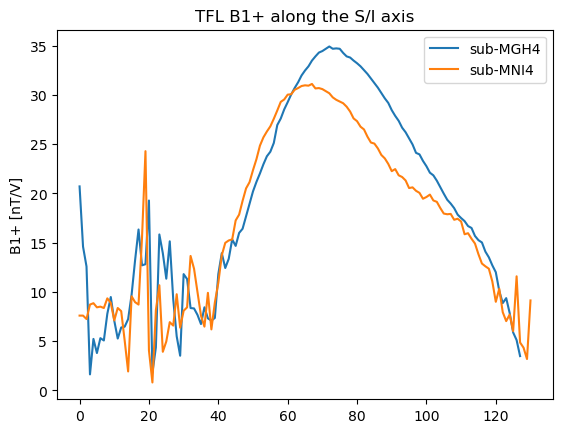

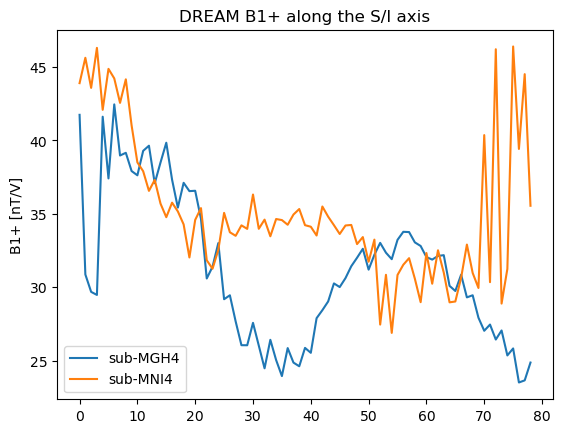


--
Spinal Cord Toolbox (5.3.0)

sct_image -i sub-MGH4_acq-coilQaSagLarge_SNR.nii.gz -split t -o sub-MGH4_acq-coilQaSagLarge_SNR.nii.gz
--

Generate output files...
File sub-MGH4_acq-coilQaSagLarge_SNR_T0000.nii.gz already exists. Will overwrite it.
File sub-MGH4_acq-coilQaSagLarge_SNR_T0001.nii.gz already exists. Will overwrite it.
File sub-MGH4_acq-coilQaSagLarge_SNR_T0002.nii.gz already exists. Will overwrite it.
File sub-MGH4_acq-coilQaSagLarge_SNR_T0003.nii.gz already exists. Will overwrite it.
File sub-MGH4_acq-coilQaSagLarge_SNR_T0004.nii.gz already exists. Will overwrite it.
File sub-MGH4_acq-coilQaSagLarge_SNR_T0005.nii.gz already exists. Will overwrite it.

Done! To view results, type:
fsleyes sub-MGH4_acq-coilQaSagLarge_SNR_T0000.nii.gz sub-MGH4_acq-coilQaSagLarge_SNR_T0001.nii.gz sub-MGH4_acq-coilQaSagLarge_SNR_T0002.nii.gz sub-MGH4_acq-coilQaSagLarge_SNR_T0003.nii.gz sub-MGH4_acq-coilQaSagLarge_SNR_T0004.nii.gz sub-MGH4_acq-coilQaSagLarge_SNR_T0005.nii.gz &


--
Spinal Cor

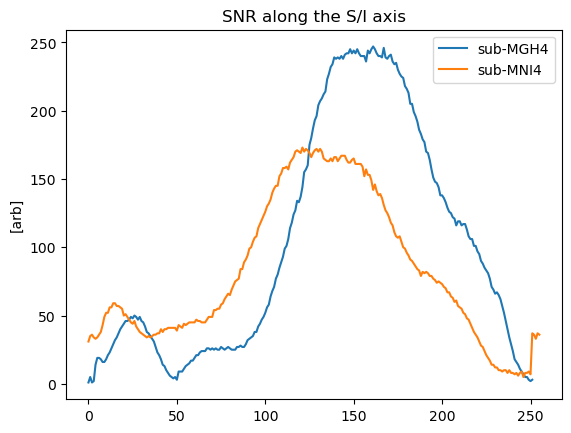

In [33]:
# figure types
fig_types = ["TFL B1+ along the S/I axis", "DREAM B1+ along the S/I axis","SNR along the S/I axis"]
file_names = ["TFLTB1map", "DREAMTB1avgB1map","acq-coilQaSagLarge_SNR_T0000"]

for fig_type, file_name in zip(fig_types, file_names):

    fig=plt.plot()

    for subject in subjects:
        
        os.chdir(os.path.join(path_data, f"{subject}", "fmap"))

        if file_name=="acq-coilQaSagLarge_SNR_T0000":
            # Splitting SNR map 
            !sct_image -i {subject}_acq-coilQaSagLarge_SNR.nii.gz -split t -o {subject}_acq-coilQaSagLarge_SNR.nii.gz
    
        # Load data
        map=nib.load(f"{subject}_{file_name}.nii.gz")

        if file_name=="acq-coilQaSagLarge_SNR_T0000":
            data=map.get_fdata()[round(map.get_fdata().shape[0]/2),125:385,round(map.get_fdata().shape[2]/2)]
        else:
            data=map.get_fdata()[round(map.get_fdata().shape[0]/2),:,round(map.get_fdata().shape[2]/2)]
            
        data=map.get_fdata()[round(map.get_fdata().shape[0]/2),:,round(map.get_fdata().shape[2]/2)]
        data = data[np.nonzero(data)] 
    
        plt.plot(data,label=subject)

    plt.legend()
    plt.title(fig_type)
    
    if file_name=="acq-coilQaSagLarge_SNR_T0000":
        plt.ylabel("[arb]")
    else:
        plt.ylabel("B1+ [nT/V]")
    plt.show()
    


In [ ]:
##############################################################################################
# generate figures for B1+ and SNR maps obtained at each site (for one representative subject)
##############################################################################################

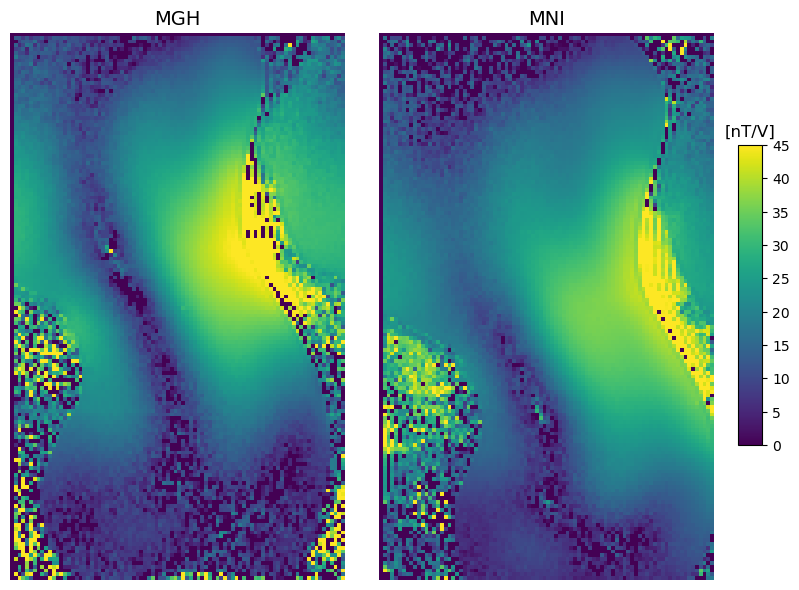

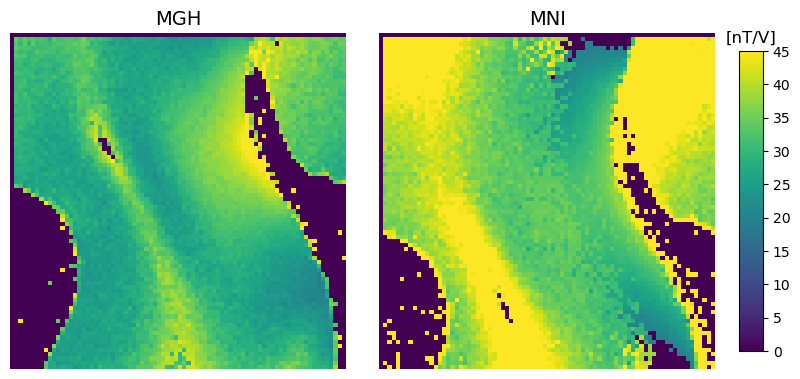

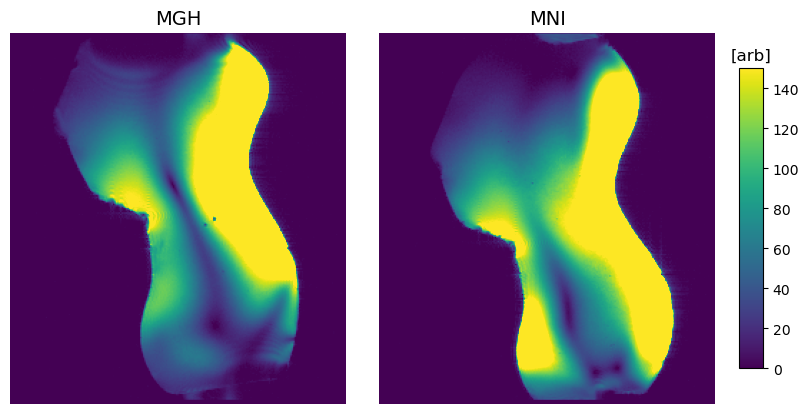

In [38]:
#sites = ["MGH", "MNI", "NYU"]
sites = ["MGH", "MNI"]

# map types
map_types = ["TFLTB1map", "DREAMTB1avgB1map", "acq-coilQaSagLarge_SNR_T0000"]

# legend types
legend_types = ["[nT/V]", "[nT/V]", "[arb]"]

# Select subject to show
subject = '4'

for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, len(sites), figsize=(8, 6))
    font_size = 14
    axes=axes.flatten()
        
    for i,site in enumerate(sites):
        # Load data
        os.chdir(os.path.join(path_data, f"sub-{site}{subject}", "fmap"))
        map=nib.load(f"sub-{site}{subject}_{map_type}.nii.gz")
        
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            map=map.get_fdata()[115:350,125:385,round(map.get_fdata().shape[2]/2)]
        else:
            map=map.get_fdata()[:,:,round(map.get_fdata().shape[2]/2)]
    
        # Plot
        # Defining dynamic range
        dynmin = 0 
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            dynmax = 150
        else:
            dynmax = 45    

        splot=axes[i]
        
        im = splot.imshow((map.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)
        splot.set_title(site, size=font_size)
        splot.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0, right=0.9)

    # Colorbar
    # Assume that the colorbar should start at the bottom of the lower row of subplots and
    # extend to the top of the upper row of subplots
    cbar_bottom = 0.25  # This might need adjustment
    cbar_height = 0.5  # This represents the total height of both rows of subplots
    cbar_ax = fig.add_axes([0.93, cbar_bottom, 0.03, cbar_height])
    cbar = plt.colorbar(im, cax=cbar_ax)

    cbar_ax.set_title(legend_type, size=12)
    plt.show()


## Generate figures for debugging/QC

In [ ]:
##################################################################################
# load data and plot B1+ along the cord for individual subjects
##################################################################################

In [ ]:
def signal_extractor_from_csv(csv_filename):
  # Load the CSV file into a Pandas DataFrame
  dataframe = pd.read_csv(csv_filename, index_col='Slice (I->S)')
  # Convert all the strings (123.4242, etc) of the WA column into actual numerical values
  dataframe['WA()'] = pd.to_numeric(dataframe['WA()'], errors='coerce')
  WA_matrix = dataframe['WA()'].to_numpy()
  return WA_matrix

TFL_b1_iqrs = []
TFL_B1_nTpV_along_cord_list = []

DREAM_b1_iqrs = []
DREAM_B1_nTpV_along_cord_list = []

for subject in subjects:
    TFL_B1_nTpV_along_cord = signal_extractor_from_csv(os.path.join(path_results, subject + "_TFLTB1map.csv"))
    TFL_B1_nTpV_along_cord = TFL_B1_nTpV_along_cord[~np.isnan(TFL_B1_nTpV_along_cord)] # remove NaNs
    TFL_B1_nTpV_along_cord_list.append(TFL_B1_nTpV_along_cord)
    plt.plot(TFL_B1_nTpV_along_cord)
    TFL_B1_nTpV_along_cord_mean = np.round(np.mean(TFL_B1_nTpV_along_cord))
    std = np.std(TFL_B1_nTpV_along_cord)
    titlestring= f"TFL B1+ efficiency [nT/V] along the cord. Mean value: {TFL_B1_nTpV_along_cord_mean} Std: {std}"
    TFL_b1_iqrs.append(iqr(TFL_B1_nTpV_along_cord))
    plt.title(titlestring)
    plt.xlabel('Slice along the I-->S direction')
    plt.ylabel('nT/V')
    plt.show()  
    
    DREAM_B1_nTpV_along_cord = signal_extractor_from_csv(os.path.join(path_results, subject + "_DREAMTB1map.csv"))
    DREAM_B1_nTpV_along_cord = DREAM_B1_nTpV_along_cord[~np.isnan(DREAM_B1_nTpV_along_cord)] # remove NaNs
    DREAM_B1_nTpV_along_cord_list.append(DREAM_B1_nTpV_along_cord)
    plt.plot(DREAM_B1_nTpV_along_cord)
    DREAM_B1_nTpV_along_cord_mean = np.round(np.mean(DREAM_B1_nTpV_along_cord))
    std = np.std(DREAM_B1_nTpV_along_cord)
    titlestring= f"DREAM B1+ efficiency [nT/V] along the cord. Mean value: {DREAM_B1_nTpV_along_cord_mean} Std: {std}"
    DREAM_b1_iqrs.append(iqr(DREAM_B1_nTpV_along_cord))
    plt.title(titlestring)
    plt.xlabel('Slice along the I-->S direction')
    plt.ylabel('nT/V')
    plt.show()  
    

    
    



In [ ]:
##################################################################################
# plot B1+ along the cord for all subjects in one figure
##################################################################################

In [ ]:
sites = ["MGH", "MNI"]
subject_names = ["Subject D", "Subject L", "Subject R"]

##################################################################################
# Plot TFL B1+ data
##################################################################################
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(16, 6)

j = 0
for i in range(len(sites)): 
    axs[i].plot(TFL_B1_nTpV_along_cord_list[j])
    axs[i].plot(TFL_B1_nTpV_along_cord_list[j+1])
    axs[i].plot(TFL_B1_nTpV_along_cord_list[j+2])
    axs[i].set_title(sites[i])
    j = j + 3

axs[i].legend(subject_names,loc="upper right")


for ax in axs.flat:
    ax.set(xlabel='Slice along the I-->S direction', ylabel='TFL B1+ [nT/V]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

##################################################################################
# Plot DREAM B1+ data
##################################################################################
fig = plt.figure()
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.set_size_inches(16, 6)

j = 0
for i in range(len(sites)): 
    axs[i].plot(DREAM_B1_nTpV_along_cord_list[j])
    axs[i].plot(DREAM_B1_nTpV_along_cord_list[j+1])
    axs[i].plot(DREAM_B1_nTpV_along_cord_list[j+2])
    axs[i].set_title(sites[i])
    j = j + 3

axs[i].legend(subject_names,loc="upper right")


for ax in axs.flat:
    ax.set(xlabel='Slice along the I-->S direction', ylabel='DREAM B1+ [nT/V]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
##################################################################################
# plot B1+ IQR along the cord for all subjects in one figure
##################################################################################

In [ ]:
##################################################################################
# Plot TFL B1+ data
##################################################################################
series = [TFL_b1_iqrs[i::3] for i in range(3)]
hline_x = np.array([0, 1])
hline_width = 0.25

fig, ax = plt.subplots()
for subject_name, subject_series in zip(subject_names, series):
    ax.scatter(sites, subject_series, label=subject_name)
plt.hlines([np.mean(TFL_b1_iqrs[i:i+2]) for i in range(0, len(TFL_b1_iqrs), 3)], hline_x - hline_width/2, hline_x + hline_width/2, color="black", label="Across subj. mean")
ax.legend()
ax.set_ylim(2, 20)
ax.set_title("TFL B1+ IQR across slices within SC ROI")
plt.show()

##################################################################################
# Plot DREAM B1+ data
##################################################################################
series = [DREAM_b1_iqrs[i::3] for i in range(3)]
hline_x = np.array([0, 1])
hline_width = 0.25

fig, ax = plt.subplots()
for subject_name, subject_series in zip(subject_names, series):
    ax.scatter(sites, subject_series, label=subject_name)
plt.hlines([np.mean(DREAM_b1_iqrs[i:i+2]) for i in range(0, len(DREAM_b1_iqrs), 3)], hline_x - hline_width/2, hline_x + hline_width/2, color="black", label="Across subj. mean")
ax.legend()
ax.set_ylim(0, 5)
ax.set_title("DREAM B1+ IQR across slices within SC ROI")
plt.show()

## Finished

In [ ]:
# Indicate duration of data processing

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

# Convert seconds to a timedelta object
total_time_delta = timedelta(seconds=total_time)

# Format the timedelta object to a string
formatted_time = str(total_time_delta)

# Pad the string representation if less than an hour
formatted_time = formatted_time.rjust(8, '0')

print(f"Total Runtime [hour:min:sec]: {formatted_time}")